In [3]:
#複製darknet
!git clone https://github.com/AlexeyAB/darknet.git

fatal: destination path 'darknet' already exists and is not an empty directory.


In [4]:
#修改MakeFile
!sed -i "s/GPU=0/GPU=1/g" darknet/Makefile
!sed -i "s/CUDNN=0/CUDNN=1/g" darknet/Makefile
!sed -i "s/OPENCV=0/OPENCV=1/g" darknet/Makefile

In [5]:
#編譯YOLO
! cd darknet; make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

# **檢視訓練資料集**

In [6]:
#colab連接到GOOGLE Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#從Google Drive下載資料
! cp "/content/drive/MyDrive/AIDataset/medical-masks-dataset.zip" /content/

In [8]:
#資料解壓縮
! unzip /content/medical-masks-dataset.zip > data_unzip.log

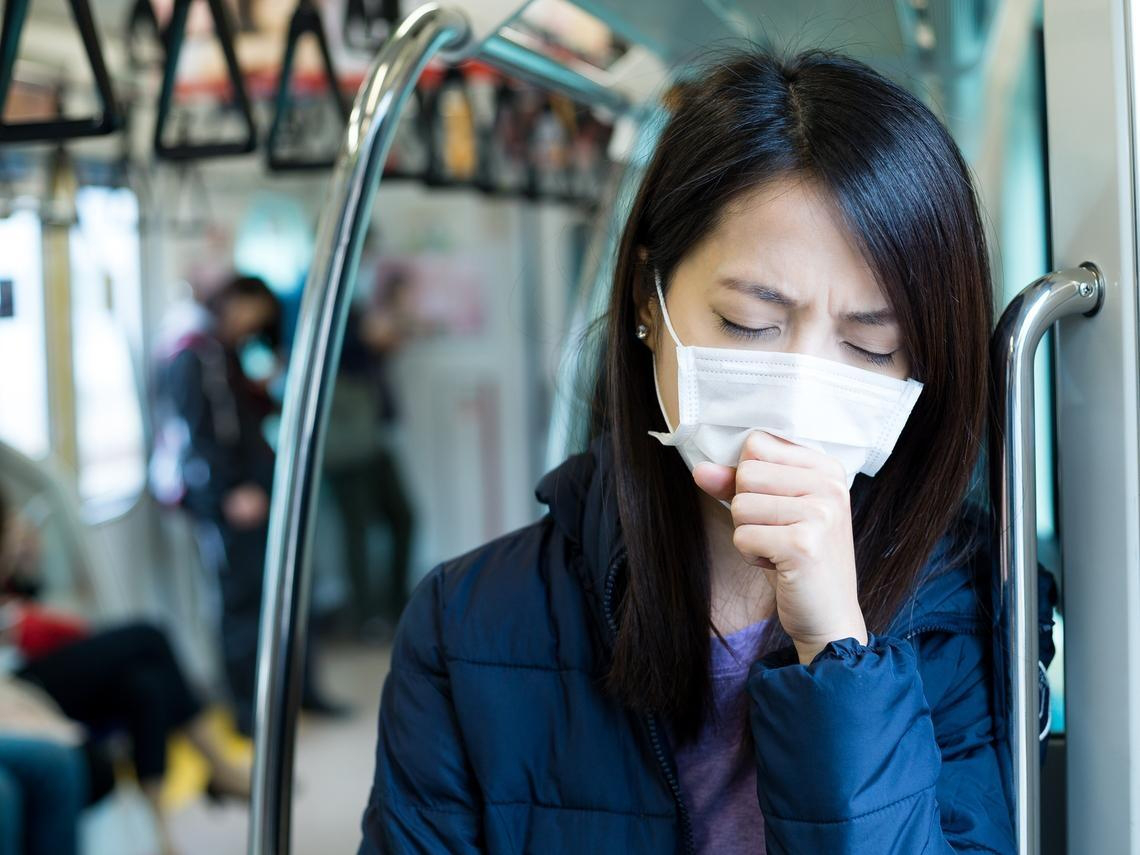

In [9]:
#查看照片
from PIL import Image
img = Image.open('/content/images/012106.jpg_1140x855.jpg')
img

In [10]:
#查看圖片對應的XML
! cat /content/labels/012106.jpg_1140x855.xml

<annotation>
	<folder>images</folder>
	<filename>012106.jpg_1140x855.jpg</filename>
	<path>P:\mask_mouth\images\012106.jpg_1140x855.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>1140</width>
		<height>855</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>good</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>654</xmin>
			<ymin>275</ymin>
			<xmax>910</xmax>
			<ymax>517</ymax>
		</bndbox>
	</object>
</annotation>


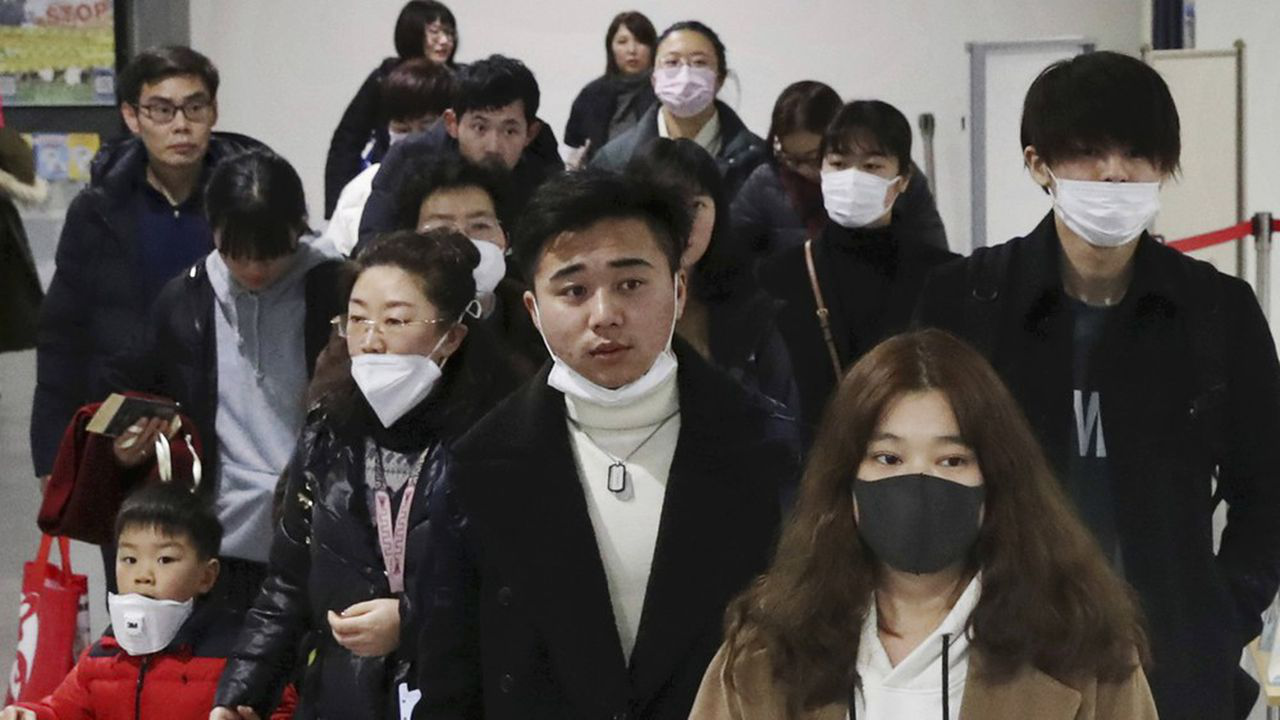

In [11]:
#查看照片
from PIL import Image
img = Image.open('/content/images/0602623232127-web-tete.jpg')
img

In [12]:
#查看圖片對應的XML
! cat /content/labels/0602623232127-web-tete.xml

<annotation>
	<folder>images</folder>
	<filename>0602623232127-web-tete.jpg</filename>
	<path>P:\mask_mouth\images\0602623232127-web-tete.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>1280</width>
		<height>720</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>bad</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>134</xmin>
			<ymin>84</ymin>
			<xmax>220</xmax>
			<ymax>166</ymax>
		</bndbox>
	</object>
	<object>
		<name>bad</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>420</xmin>
			<ymin>16</ymin>
			<xmax>460</xmax>
			<ymax>63</ymax>
		</bndbox>
	</object>
	<object>
		<name>bad</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>610</xmin>
			<ymin>26</ymin>
			<xmax>656</xmax>
			<ymax>77</ymax>
		</bndbox>
	</object>
	<object>
		<name>good</n

In [13]:
#建立YOLO資料夾
! rm -rf /content/yolo
! mkdir /content/yolo

In [14]:
from bs4 import BeautifulSoup
import os
import shutil

#建置一個status_dic
status_dic = {'good': 2, 'bad': 1, 'none': 0}

def getYoloFormat(filename,label_path, img_path, yolo_path, newname):
    with open(label_path+ filename, 'r') as f:
        #讀取xml
        soup = BeautifulSoup(f.read(), 'xml')
        imgname = soup.select_one('filename').text
        image_w = int(soup.select_one('width').text)
        image_h = int(soup.select_one('height').text)
        ary = []
        
        for obj in soup.select('object'):
            #取出xmin, xmax, ymin, ymax，並用status_dic轉換
            xmin = int(obj.select_one('xmin').text)
            xmax = int(obj.select_one('xmax').text)
            ymin = int(obj.select_one('ymin').text)
            ymax = int(obj.select_one('ymax').text)
            objclass = status_dic.get(obj.select_one('name').text)

            #轉成YOLO格式
            x = (xmin + (xmax-xmin)/2) * 1.0 / image_w
            y = (ymin + (ymax-ymin)/2) * 1.0 / image_h
            w = (xmax-xmin) * 1.0 / image_w
            h = (ymax-ymin) * 1.0 / image_h
            ary.append(' '.join([str(objclass), str(x),str(y),str(w),str(h)]))

        if os.path.exists(img_path + imgname):
            #把圖片移到yolo之下，同時把參數寫到yolo之下
            shutil.copyfile(img_path + imgname, yolo_path + newname + '.jpg')
            with open(yolo_path + newname + '.txt', 'w') as f:
                f.write('\n'.join(ary))

In [15]:
import os
#設定路徑
labelpath = '/content/labels/'
imgpath = '/content/images/'
yolopath = '/content/yolo/'
ary = []

for idx, f in enumerate(os.listdir(labelpath)):
    try:
        #透過getYoloFromat將圖像爛參數檔寫到YOLO下
        getYoloFormat(f, labelpath,imgpath, yolopath, str(idx))
    except Exception as e:
        print(e)

float division by zero


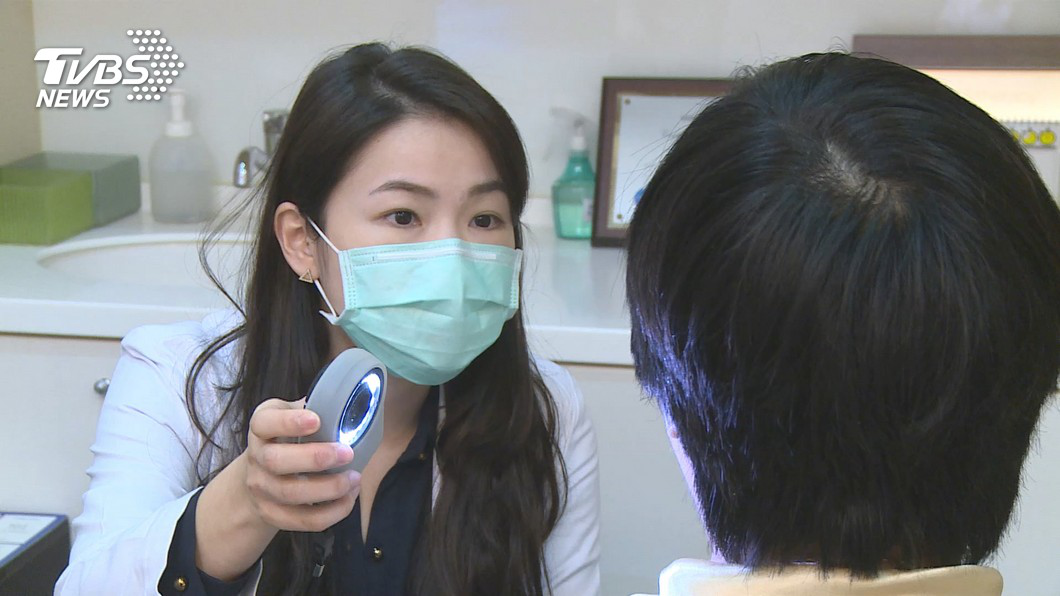

In [16]:
from PIL import Image
Image.open('/content/yolo/0.jpg')

In [17]:
#觀察對應的標記檔
! cat /content/yolo/0.txt

2 0.4047169811320755 0.47231543624161076 0.18679245283018867 0.3640939597315436

# **準備訓練與測試資料集**

In [18]:
#建立cfg_mask資料夾
! rm -rf /content/cfg_mask
! mkdir /content/cfg_mask

In [19]:
#/content/yolo/中從取出前80%的資料
import os
datasets = ['/content/yolo/'+ f for f in os.listdir('/content/yolo/') if not f.endswith('.txt')]
len(datasets) * 0.8

541.6

In [20]:
with open('/content/cfg_mask/train.txt', 'w') as f:
    #打開前80%的資料寫入train.txt
    f.write('\n'.join(datasets[0:540]))

In [21]:
with open('/content/cfg_mask/test.txt', 'w') as f:
    #打開後20%的資料寫入test.txt
    f.write('\n'.join(datasets[540:]))

# **複製參數檔案**

In [22]:
! cp "/content/drive/MyDrive/AIDataset/obj.data" cfg_mask/
! cp "/content/drive/MyDrive/AIDataset/obj.names" cfg_mask/

In [23]:
! head /content/cfg_mask/obj.data

classes= 3
train  = /content/cfg_mask/train.txt
valid  = /content/cfg_mask/test.txt
names  = /content/cfg_mask/obj.names
backup = /content/cfg_mask/weights/

In [24]:
! head /content/cfg_mask/obj.names

none
bad
good


# **建立權重資料夾**

In [25]:
#建立權重資料夾
! mkdir /content/cfg_mask/weights

# **YOLO v4 架構**





<img src='https://img.onl/C3TuF0' width="800px" />

# Backbone — CSPDarknet53
<img src='https://img.onl/ZuSj6W' width="500px" />


# Neck — SPP + PAN
<img src='https://img.onl/wypYRg' width="500px" />
<img src='https://img.onl/UjWSq' width="500px" />

修改 yolo-obj.cfg
*   修改batch=64，修改subdivisions=64（如果顯示卡效能較高，可以設定batch=96或subdivisions=16）
*   修改width=416，height=416（如果顯示卡效能較高，可以設定width=608，height=608）
*   修改max_batches=classes*2000，例如當前有3個類別，則設定為6000，這裡的max_batches表示最終的迭代次數
*   修改steps為max_batches的80%到90%，比如max_batches=6000，則steps=4800,5400
*   YOLOV4 偵測的濾鏡(filter) 大小為 (C+5)*B.
*   B 是每個Feature Map 可以偵測的Bounding Box 數量  =>縮放三個尺寸，所以B=3
*   5 是Bounding Box 的x,y,w,h 以及 Confidence
*   C 是類別數量
*   filters=(classes + 5)*3 # 24
*   classes=3





In [26]:
! cp /content/darknet/cfg/yolo-obj.cfg /content/cfg_mask/ 

In [27]:
! sed -n -e 963p -e 970p -e 1051p -e 1058p -e 1139p -e 1146p /content/cfg_mask/yolo-obj.cfg

filters=255
classes=80
filters=255
classes=80
filters=255
classes=80


In [28]:
#修改參數
! sed -i '963s/255/24/' /content/cfg_mask/yolo-obj.cfg
! sed -i '970s/80/3/' /content/cfg_mask/yolo-obj.cfg
! sed -i '1051s/255/24/' /content/cfg_mask/yolo-obj.cfg
! sed -i '1058s/80/3/' /content/cfg_mask/yolo-obj.cfg
! sed -i '1139s/255/24/' /content/cfg_mask/yolo-obj.cfg
! sed -i '1146s/80/3/' /content/cfg_mask/yolo-obj.cfg

In [29]:
! sed -n -e 963p -e 970p -e 1051p -e 1058p -e 1139p -e 1146p /content/cfg_mask/yolo-obj.cfg

filters=24
classes=3
filters=24
classes=3
filters=24
classes=3


# **開始訓練模型**
複製權重
*   CSPDarknet53: 利用Imagenet 訓練出來的 53 層預訓練模型

In [30]:
#!wget https://pjreddie.com/media/files/yolov4.conv.137
! cp "/content/drive/MyDrive/AIDataset/yolov4.conv.137" /content/cfg_mask/

# **訓練模型**

In [32]:
#訓練模型
! darknet/darknet detector train /content/cfg_mask/obj.data /content/cfg_mask/yolo-obj.cfg /content/cfg_mask/yolov4.conv.137 -dont_show

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
yolo-obj
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 64, time_steps = 1, train = 1 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv     64       1 x 1/ 

# **辨識圖片中的人物是否有戴口罩**

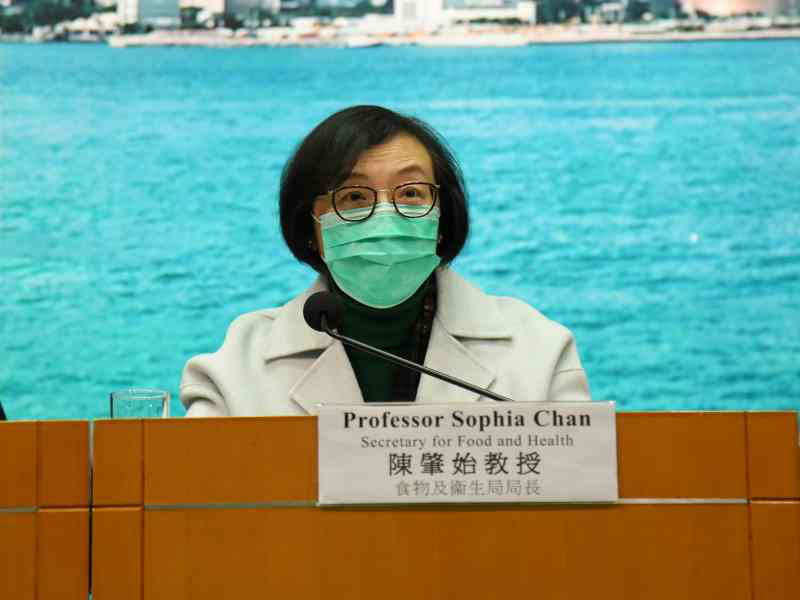

In [33]:
#辨識圖片中的人物是否有戴口罩
from PIL import Image
Image.open('yolo/513.jpg')

In [36]:
#執行辨識
! cd darknet; ./darknet detector test /content/cfg_mask/obj.data /content/cfg_mask/yolo-obj.cfg /content/cfg_mask/weights/yolo-obj_last.weights /content/yolo/513.jpg

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 64, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv     64       1 x 1/ 1    208 

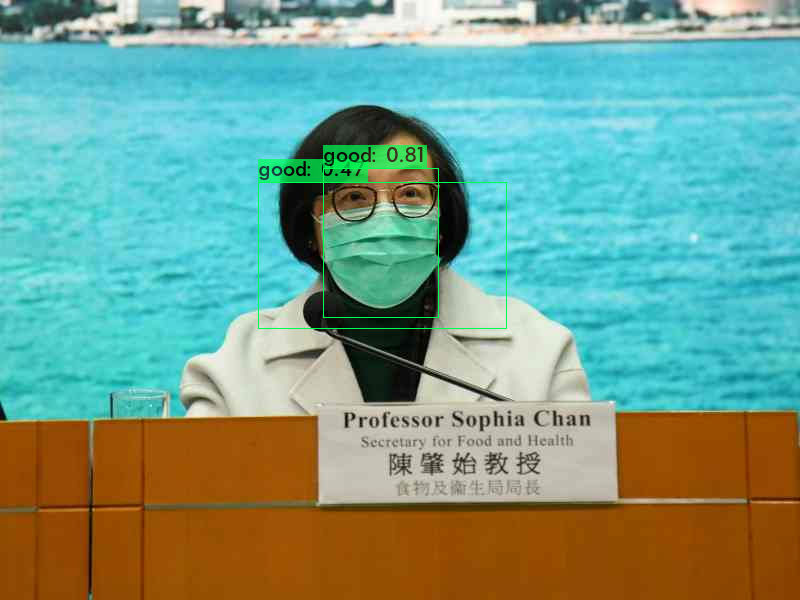

In [37]:
from PIL import Image
Image.open('/content/darknet/predictions.jpg')

In [38]:
! cp "/content/drive/MyDrive/AIDataset/test.jpg" /content/

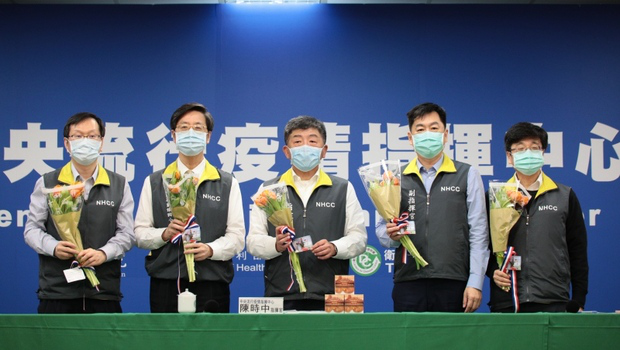

In [39]:
from PIL import Image
Image.open('/content/test.jpg')

In [40]:
#辨識陳時中的是否有戴口罩
! cd darknet; ./darknet detector test /content/cfg_mask/obj.data /content/cfg_mask/yolo-obj.cfg /content/cfg_mask/weights/yolo-obj_last.weights /content/test.jpg

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 64, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv     64       1 x 1/ 1    208 

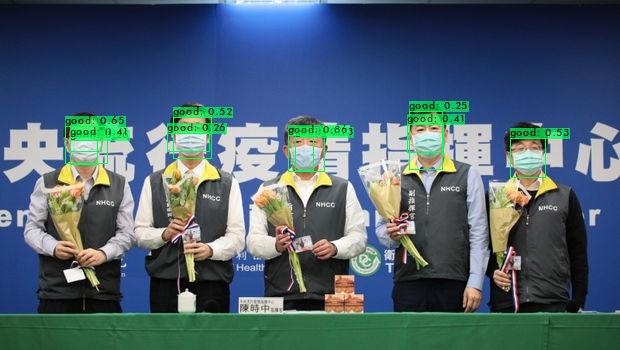

In [41]:
from PIL import Image
Image.open('/content/darknet/predictions.jpg')